In [1]:
import torch
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

In [2]:
# Define data transformations for training, validation, and test sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_data = datasets.ImageFolder(root='/kaggle/input/kkkki45/FER2013/train', transform=train_transforms)

test_data = datasets.ImageFolder(root='/kaggle/input/kkkki45/FER2013/test', transform=test_transforms)

# Define data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [3]:
# Get the shape of images in train and test sets
train_images_shape = next(iter(train_loader))[0].shape
test_images_shape = next(iter(test_loader))[0].shape

print("shape (training set):", train_images_shape)
print("shape (test set):", test_images_shape)

# Count of images
train_count = len(train_data)
test_count = len(test_data)

print("training set:", train_count)
print("test set:", test_count)


shape (training set): torch.Size([128, 3, 224, 224])
shape (test set): torch.Size([128, 3, 224, 224])
training set: 28227
test set: 7060


In [4]:
num_classes_train = len(train_data.classes)
num_classes_test = len(test_data.classes)

print("Number of classes in training set:", num_classes_train)
print("Number of classes in test set:", num_classes_test)

Number of classes in training set: 6
Number of classes in test set: 6


In [5]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResidualLayer(nn.Module):
    def __init__(self, block, in_channels, out_channels, blocks, stride=1):
        super(ResidualLayer, self).__init__()
        self.layers = nn.Sequential(
            block(in_channels, out_channels, stride),
            *[block(out_channels, out_channels) for _ in range(1, blocks)]
        )

    def forward(self, x):
        return self.layers(x)

class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=6):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = ResidualLayer(block, 64, 256, layers[0], stride=1)
        self.layer2 = ResidualLayer(block, 256, 512, layers[1], stride=2)
        self.layer3 = ResidualLayer(block, 512, 1024, layers[2], stride=2)
        self.layer4 = ResidualLayer(block, 1024, 2048, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x


# Create a ResNet model
# resnet = ResNet18(ResidualBlock, [2, 2, 2, 2], num_classes=1)

In [6]:
import torch.optim as optim
from torch.autograd import Variable

epochs = 20
epoch_loss = [0] * epochs
epoch_accuracy = [0] * epochs

model = ResNet50(ResidualBlock, [3, 4, 6, 3], num_classes=6)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    count = 0


    for i, data in enumerate(train_loader):
        inputs, labels = data
        # labels = labels.squeeze(1).float().cuda()
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())


        optimizer.zero_grad()
        with torch.autocast(device_type='cuda'):
          outputs = model(inputs)

          _ , preds = torch.max(outputs,1)
          accuracy = torch.sum(preds == labels).item() / len(preds)
          running_corrects += torch.sum(preds == labels).item()
          count += len(preds)

          # print(outputs.shape)
          # print(labels.shape)
          loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # print(loss.item())

    epoch_loss[epoch] = running_loss / len(train_loader)
    epoch_accuracy[epoch] = running_corrects / count
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_loader)}, accuracy: {running_corrects / count:.3f}')
    torch.save(model, f'./resnet50.pkl')

    running_counts = 0
    running_loss = 0.0
    count = 0 

[1,   221] loss: 1.7436943766218505, accuracy: 0.256
[2,   221] loss: 1.7135183142321142, accuracy: 0.278
[3,   221] loss: 1.6833706554783956, accuracy: 0.305
[4,   221] loss: 1.6547921858222236, accuracy: 0.324
[5,   221] loss: 1.619935453207784, accuracy: 0.368
[6,   221] loss: 1.56986227510202, accuracy: 0.425
[7,   221] loss: 1.5325433841118445, accuracy: 0.461
[8,   221] loss: 1.507982779412248, accuracy: 0.485
[9,   221] loss: 1.485854525371914, accuracy: 0.507
[10,   221] loss: 1.4668970027120944, accuracy: 0.525
[11,   221] loss: 1.4523955680665928, accuracy: 0.540
[12,   221] loss: 1.4399965079122, accuracy: 0.553
[13,   221] loss: 1.4260364398697383, accuracy: 0.565
[14,   221] loss: 1.4155074163799373, accuracy: 0.573
[15,   221] loss: 1.4058011187687178, accuracy: 0.583
[16,   221] loss: 1.3952921580405258, accuracy: 0.593
[17,   221] loss: 1.390840414962078, accuracy: 0.600
[18,   221] loss: 1.382542307020852, accuracy: 0.608
[19,   221] loss: 1.3770567588676694, accuracy:

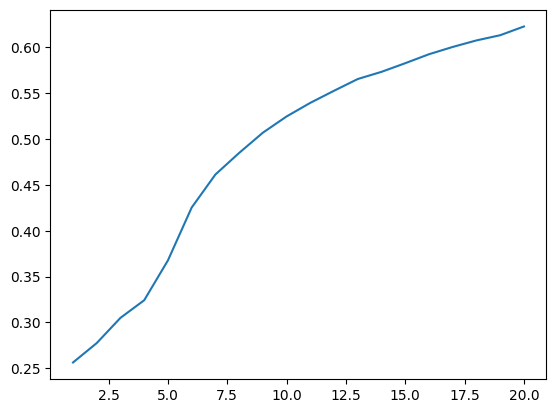

In [8]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,epoch+2)), epoch_accuracy)

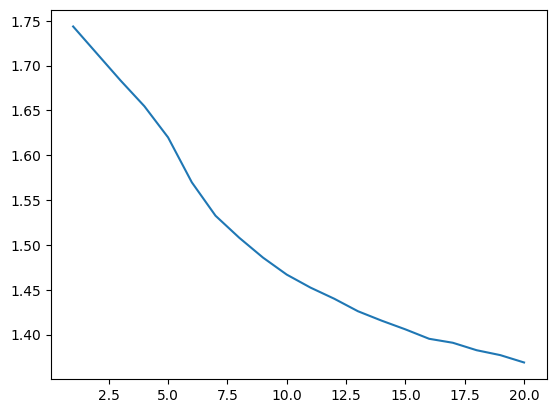

In [9]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,epoch+2)), epoch_loss)

In [10]:
model = torch.load('resnet50.pkl', map_location=torch.device('cuda'))

model_instance = ResNet50(ResidualBlock, [3, 4, 6, 3], num_classes=6)

# Load the state_dict from the loaded model
model_instance.load_state_dict(model.state_dict())

# Move the model to CUDA
model_instance = model_instance.cuda()
model_instance.eval()

# Initialize variables for evaluation
test_loss = 0.0
test_corrects = 0
test_count = 0

criterion = nn.CrossEntropyLoss()

# Evaluate the model on the test set
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model_instance(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_corrects += torch.sum(preds == labels).item()
        test_count += len(preds)

# Calculate average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
accuracy = test_corrects / test_count

print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

Test Loss: 1.4482, Accuracy: 0.5375


Test Loss: 1.4482, Accuracy: 0.5375


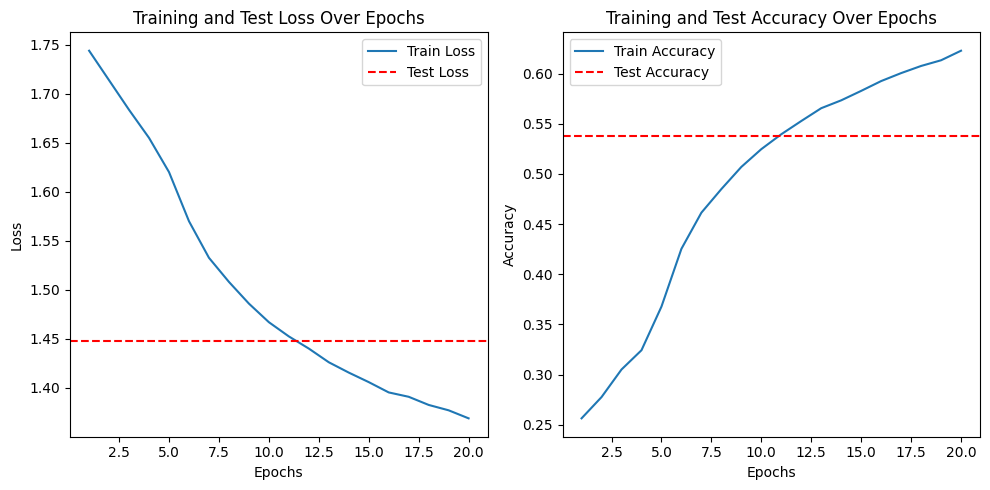

In [11]:
# Assuming you have epoch_loss and epoch_accuracy defined
epochs = list(range(1, epoch + 2))

# Initialize variables for evaluation
test_loss = 0.0
test_corrects = 0
test_count = 0

# Evaluate the model on the test set
model_instance.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        outputs = model_instance(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        test_loss += loss.item()
        test_corrects += torch.sum(preds == labels).item()
        test_count += len(preds)

# Calculate average loss and accuracy for the test set
avg_test_loss = test_loss / len(test_loader)
accuracy = test_corrects / test_count

# Print test results
print(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Plotting loss and accuracy for both training and test sets
plt.figure(figsize=(10, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_loss, label='Train Loss')
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_accuracy, label='Train Accuracy')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()